In [274]:
import os
import sys

import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colors
from hydra import initialize, compose
import pickle
from glob import glob
from pprint import pprint
from tqdm import tqdm
from slsim.Observations.roman_speclite import configure_roman_filters
from slsim.Observations.roman_speclite import filter_names
import speclite.filters
import matplotlib.patches as mpatches
import scipy
from phrosty import plotting
from scipy.stats import chi2

# set paths to various directories based on the machine this code is being executed on
try:
    with initialize(version_base=None, config_path='config'):  
        config = compose(config_name='config.yaml')  # overrides=['machine=uzay']
except:
    with initialize(version_base=None, config_path='../../config'):  
        config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, figure_dir, pickle_dir, repo_dir  = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

from mejiro.lenses.test import SampleStrongLens
from mejiro.plots import diagnostic_plot, plot, plot_util, overplot
from mejiro.analysis import stats
from mejiro.utils import util
from mejiro.helpers import gs
from mejiro.instruments.roman import Roman

In [275]:
save_dir = os.path.join(config.machine.data_dir, 'output', 'lowest_detectable_subhalo_mass_dev')
results = util.unpickle_all(save_dir, 'results_', '.pkl')

pval_threshold = 0.001  # three sigma

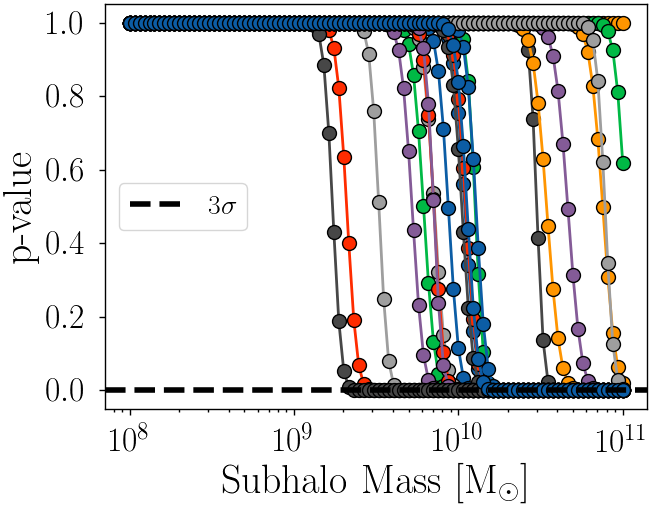

In [276]:
sample_position_key = list(results[0].keys())[3]

for i, result in enumerate(results):
    sample_results = result[sample_position_key]

    mass_list, median_list, maxes, mins = [], [], [], []
    for mass, pvals in sample_results.items():
        mass_list.append(mass)
        median_list.append(np.median(pvals))
        maxes.append(np.max(pvals))
        mins.append(np.min(pvals))
        uplims = np.array(maxes) - np.array(median_list)
        lolims = np.array(median_list) - np.array(mins)

    mass_list = [float(mass) for mass in mass_list]
    plt.errorbar(mass_list, median_list, yerr=[lolims, uplims], fmt='o', ls='-')  # , label=f'Lens {i + 1}', ls='-'
plt.axhline(pval_threshold, color='black', linestyle='--', label=f'3$\sigma$', zorder=1e3, lw=4)
plt.xlabel('Subhalo Mass [M$_\odot$]')
plt.ylabel('p-value')
plt.xscale('log')
# plt.ylim(0, 0.01)
# plt.xlim(1e5, 1e8)
plt.legend()
plt.savefig(os.path.join(figure_dir, 'ldsm_03_lenses.png'))
plt.show()

In [277]:
masses = np.logspace(8, 11, 100)
sides = 2

positions = []
for i in range(1, 19):
    sca = str(i).zfill(2)
    coords = Roman().divide_up_sca(sides)
    for coord in coords:
        positions.append((sca, coord))

In [278]:
# all systems must have a detectable subhalo at least somewhere in the mass range at all positions across the focal plane
results_to_delete = set()
for k, result in enumerate(results):
    for sca, sca_position in positions:
        position_key = f'{int(sca)}_{sca_position[0]}_{sca_position[1]}'
        position_results = result[position_key]

        largest_mass_pvals = position_results[str(int(masses[-1]))]
        if np.min(largest_mass_pvals) > pval_threshold:
            print(f'Result {k + 1} at position {position_key} has no detectable subhalo at largest mass {masses[-1]:.2e}')
            results_to_delete.add(k)

print(f'{len(results_to_delete)} result(s) to delete')

results = [result for i, result in enumerate(results) if i not in results_to_delete]
print(f'Keeping {len(results)} result(s)')

Result 3 at position 1_1022_1022 has no detectable subhalo at largest mass 1.00e+11
Result 3 at position 1_1022_3066 has no detectable subhalo at largest mass 1.00e+11
Result 3 at position 1_3066_1022 has no detectable subhalo at largest mass 1.00e+11
Result 3 at position 1_3066_3066 has no detectable subhalo at largest mass 1.00e+11
Result 3 at position 2_1022_1022 has no detectable subhalo at largest mass 1.00e+11
Result 3 at position 2_1022_3066 has no detectable subhalo at largest mass 1.00e+11
Result 3 at position 2_3066_1022 has no detectable subhalo at largest mass 1.00e+11
Result 3 at position 2_3066_3066 has no detectable subhalo at largest mass 1.00e+11
Result 3 at position 3_1022_1022 has no detectable subhalo at largest mass 1.00e+11
Result 3 at position 3_1022_3066 has no detectable subhalo at largest mass 1.00e+11
Result 3 at position 3_3066_1022 has no detectable subhalo at largest mass 1.00e+11
Result 3 at position 3_3066_3066 has no detectable subhalo at largest mass 1

In [279]:
array_list = []

# initialize first array (for SCA 1)
array = np.empty((sides, sides))
medians = []

# loop through positions
for sca, sca_position in tqdm(positions):
    position_key = f'{int(sca)}_{sca_position[0]}_{sca_position[1]}'

    lowest_det_masses_at_position = []
    for result in results:
        position_results = result[position_key]

        for mass in masses:
            pvals = position_results[str(int(mass))]
            mass = float(mass)
            if np.min(pvals) < pval_threshold:
                # print(f'hit threshold at {mass:.2e}')
                lowest_det_masses_at_position.append(mass)
                break
    
    assert len(lowest_det_masses_at_position) == len(results), f'Not all results have a detectable mass at position {position_key}'

    median_lowest_det_mass_at_position = np.median(lowest_det_masses_at_position)
    medians.append(median_lowest_det_mass_at_position)

    # if the last position on the SCA has been reached (top-right corner), populate the array with the masses
    if sca_position == Roman().divide_up_sca(sides)[-1]:  
        for i in range(sides):
            for j in range(sides):
                array[i, j] = medians[j * sides + i]

        array_list.append(array)

        # reset the array and median list for the next SCA
        array = np.empty((sides, sides))
        medians = []

  0%|          | 0/72 [00:00<?, ?it/s]

100%|██████████| 72/72 [00:00<00:00, 99.09it/s] 


In [280]:
def all_equal(iterator):
    iterator = iter(iterator)
    try:
        first = next(iterator)
    except StopIteration:
        return True
    return all(np.array_equal(first, x) for x in iterator)

In [281]:
# array_list = [i * np.ones((4, 4)) for i in range(1, 19)]

assert not all_equal(array_list), 'All SCAs have the same detectable mass array'

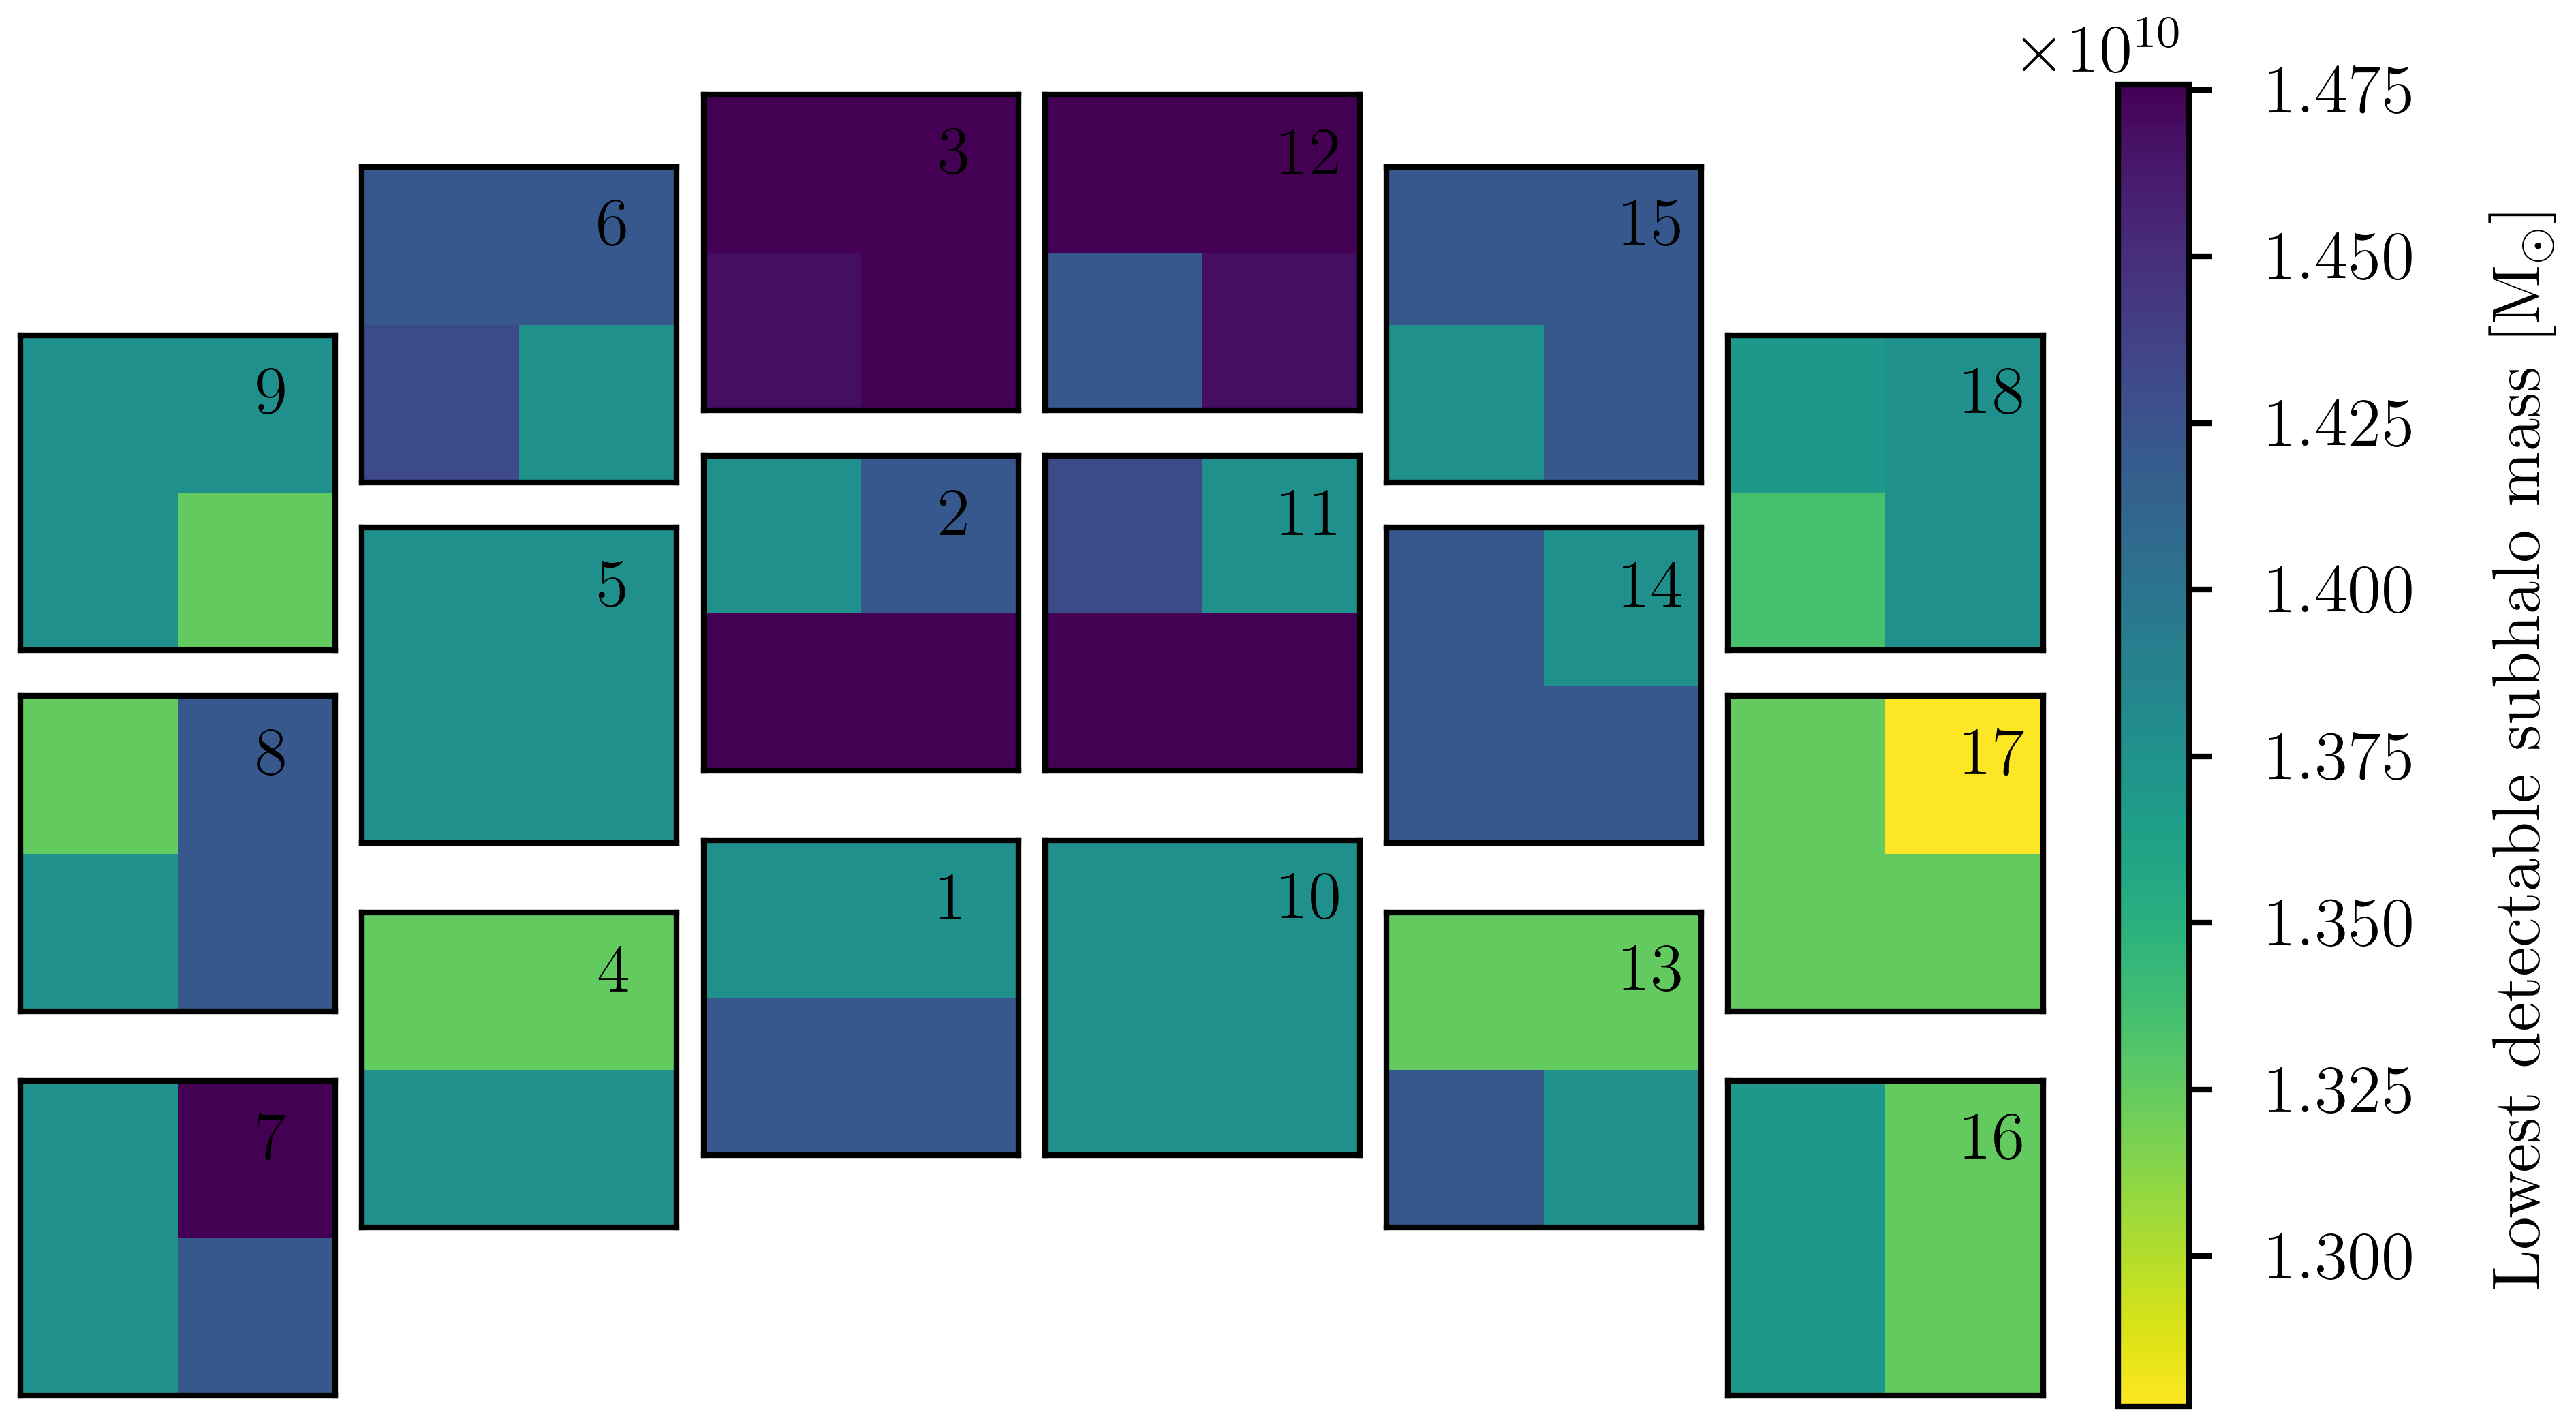

In [282]:
dev_figure_dir = os.path.join(repo_dir, 'dev')

# test: np.asarray([i * np.ones((4, 4)) for i in range(1, 19)])

plotting.roman_sca_plot(np.asarray(array_list), 
                        np.arange(1, 19), 
                        residual_plot=False, 
                        show_sca_id=True, 
                        cmap='viridis_r', 
                        savefig=False, 
                        savepath=os.path.join(dev_figure_dir, f'ldsm_{sides}_7_9_10_{len(results)}_trial1.png'), 
                        clabel=r'Lowest detectable subhalo mass [M$_\odot$]')

100%|██████████| 72/72 [00:00<00:00, 291.29it/s]


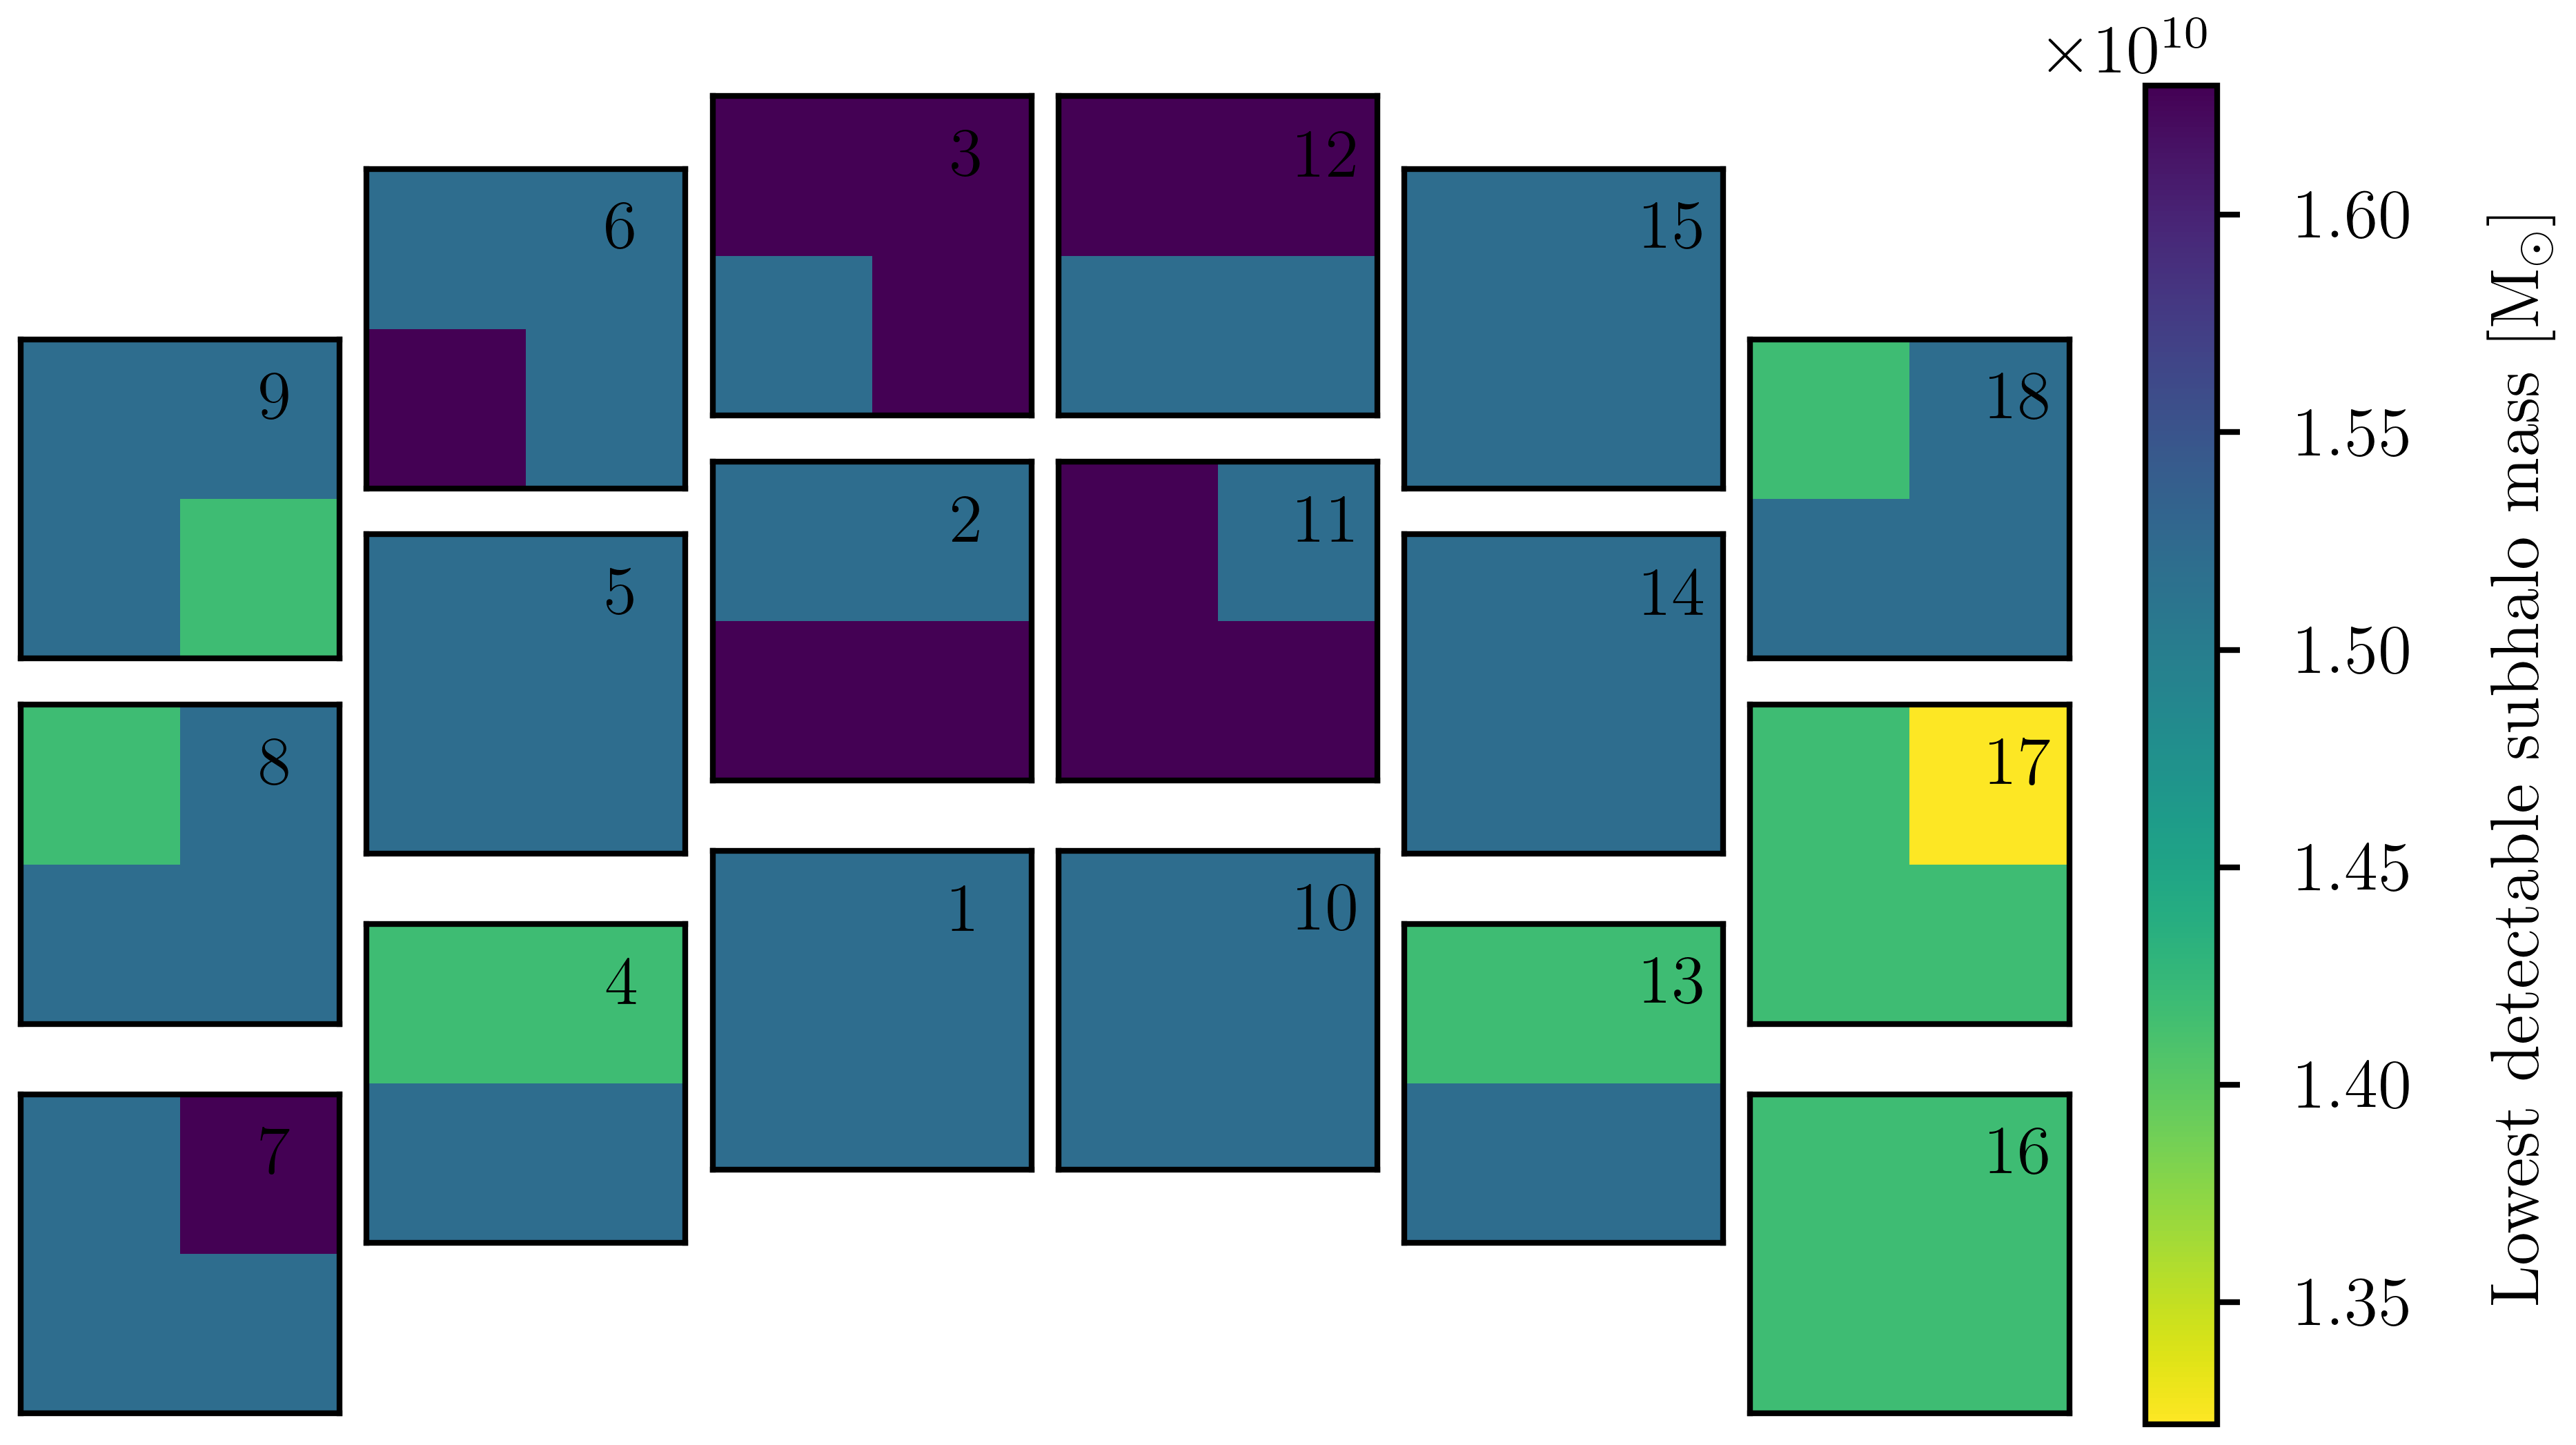

In [283]:
sample_result = np.random.choice(results, size=1)[0]

array_list = []
array = np.empty((sides, sides))
lowest_det_mass_at_position = []

for sca, sca_position in tqdm(positions):
    position_key = f'{int(sca)}_{sca_position[0]}_{sca_position[1]}'
    position_results = sample_result[position_key]

    for mass in masses:
        pvals = position_results[str(int(mass))]
        mass = float(mass)
        if np.min(pvals) < pval_threshold:
            # print(f'hit threshold at {mass:.2e}')
            lowest_det_mass_at_position.append(mass)
            break

    # if the last position on the SCA has been reached (top-right corner), populate the array with the masses
    if sca_position == Roman().divide_up_sca(sides)[-1]:  
        for i in range(sides):
            for j in range(sides):
                array[i, j] = lowest_det_mass_at_position[j * sides + i]

        array_list.append(array)

        # reset the array and median list for the next SCA
        array = np.empty((sides, sides))
        lowest_det_mass_at_position = []

plotting.roman_sca_plot(np.asarray(array_list), 
                        np.arange(1, 19), 
                        residual_plot=False, 
                        show_sca_id=True, 
                        cmap='viridis_r', 
                        savefig=False, 
                        clabel=r'Lowest detectable subhalo mass [M$_\odot$]')